# Predict Carbon Intensity of electricity production in Belgium

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
import plotly.express as px
import seaborn as sns
from sklearn.model_selection import TimeSeriesSplit

pd.set_option("display.max_column", None)
# XGboost
import xgboost as xgb

# LSTM
from sklearn.metrics import mean_squared_error
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam

## Load Data

In [2]:
df_load = pd.read_csv("BE_load_RAW20150101_20230116.csv", parse_dates=True, index_col=0)

In [3]:
df_price = pd.read_csv(
    "../Data/BE_price_RAW20150101_20230116.csv", parse_dates=True, index_col=0
)

In [4]:
df_cei = pd.read_csv(
    "../Data/BE_C0220150101_20230116.csv", parse_dates=True, index_col=0
)
# df = df[5::24] take values every 24 hours
# df["Unnamed: 0"] = df.apply(lambda x: x["Unnamed: 0"][:-6], axis=1)
df_cei.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)
df_cei.index = pd.to_datetime(df_cei.index, utc=True)
df_cei = df_cei.iloc[1:]

In [5]:
df_power = pd.read_csv(
    "../Data/BE_gen20150101_20230116.csv", parse_dates=True, index_col=0
)
# df = df[5::24] take values every 24 hours
# df["Unnamed: 0"] = df.apply(lambda x: x["Unnamed: 0"][:-6], axis=1)
df_power.rename(columns={"Unnamed: 0": "Datetime"}, inplace=True)
df_power.index = pd.to_datetime(df_power.index, utc=True)
df_power = df_power.iloc[1:]

In [6]:
df_weather = pd.read_csv(
    "../Data/POWER_Point_Hourly_20150101_20230121_050d8494N_004d3697E_LST.csv",
    parse_dates={"date": ["YEAR", "MO", "DY", "HR"]},
    skiprows=13,
    skipfooter=154,
    engine="python",
)

In [7]:
df = df_power.copy()
df["Temp"] = df_weather.T2M.values
df["PS"] = df_weather.PS.values
df["WS"] = df_weather.WS10M.values
df["HUM"] = df_weather.QV2M.values
df["CEI"] = df_cei["Carbon Intensity"]
df["Load"] = df_load["Actual Load"]
df["Price"] = df_price["0"]
df = df.drop(columns=["Renewables", "NonRenewables", "Total"])
df = df[df["Price"].notna()]
df

,Lignite,Gas,Coal,Oil,Nuclear,Other,Waste,Biomass,Geothermal,Hydro_storage,Hydro,Hydro_res,Other_renew,Solar,Wind_off,Wind_on,Temp,PS,WS,HUM,CEI,Load,Price
2015-01-04 23:00:00+00:00,0.0,1792.0,437.0,0.0,3904.0,602.0,269.0,231.0,0.0,0.0,36.0,0.0,0.0,0.0,49.0,242.0,-0.56,103.14,4.56,3.54,297.244248,10248.0,36.56
2015-01-05 00:00:00+00:00,0.0,1769.0,434.0,0.0,3905.0,573.0,266.0,231.0,0.0,0.0,36.0,0.0,0.0,0.0,72.0,283.0,-0.53,103.13,4.30,3.48,291.853613,9844.0,34.94
2015-01-05 01:00:00+00:00,0.0,1788.0,296.0,0.0,3905.0,548.0,267.0,232.0,0.0,0.0,35.0,0.0,0.0,0.0,136.0,251.0,-0.42,103.11,4.01,3.54,275.135559,9355.0,32.19
2015-01-05 02:00:00+00:00,0.0,1763.0,250.0,0.0,3904.0,501.0,268.0,234.0,0.0,0.0,35.0,0.0,0.0,0.0,206.0,310.0,-0.31,103.08,3.95,3.54,261.820238,9113.0,28.05
2015-01-05 03:00:00+00:00,0.0,1875.0,256.0,0.0,3903.0,498.0,269.0,227.0,0.0,0.0,34.0,0.0,0.0,0.0,213.0,318.0,-0.34,103.04,3.87,3.54,266.992756,9094.0,28.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 09:00:00+00:00,0.0,412.0,0.0,0.0,4901.0,0.0,104.0,121.0,0.0,0.0,6.0,0.0,0.0,755.0,2026.0,2143.0,5.73,99.64,10.31,4.82,43.355655,9153.0,26.24
2023-01-15 10:00:00+00:00,0.0,407.0,0.0,0.0,4901.0,0.0,106.0,119.0,0.0,274.0,7.0,0.0,0.0,1087.0,2041.0,2192.0,6.49,99.64,11.08,5.00,62.835100,9666.0,38.46
2023-01-15 11:00:00+00:00,0.0,406.0,0.0,0.0,4909.0,0.0,107.0,120.0,0.0,0.0,7.0,0.0,0.0,1081.0,1984.0,2234.0,6.67,99.62,12.28,5.07,42.791574,9757.0,38.86
2023-01-15 12:00:00+00:00,0.0,423.0,0.0,0.0,4901.0,0.0,105.0,122.0,0.0,0.0,7.0,0.0,0.0,848.0,2041.0,2293.0,6.65,99.57,11.97,5.13,43.464618,9743.0,28.63


## Exploratory data analysis

In [8]:
#df = df.iloc[:-500]

In [9]:
df.shape

(70383, 23)

In [10]:
df.columns

Index(['Lignite', 'Gas', 'Coal', 'Oil', 'Nuclear', 'Other', 'Waste', 'Biomass',
       'Geothermal', 'Hydro_storage', 'Hydro', 'Hydro_res', 'Other_renew',
       'Solar', 'Wind_off', 'Wind_on', 'Temp', 'PS', 'WS', 'HUM', 'CEI',
       'Load', 'Price'],
      dtype='object')

In [11]:
df.dtypes

Lignite          float64
Gas              float64
Coal             float64
Oil              float64
Nuclear          float64
Other            float64
Waste            float64
Biomass          float64
Geothermal       float64
Hydro_storage    float64
Hydro            float64
Hydro_res        float64
Other_renew      float64
Solar            float64
Wind_off         float64
Wind_on          float64
Temp             float64
PS               float64
WS               float64
HUM              float64
CEI              float64
Load             float64
Price            float64
dtype: object

In [12]:
df.describe()

,Lignite,Gas,Coal,Oil,Nuclear,Other,Waste,Biomass,Geothermal,Hydro_storage,Hydro,Hydro_res,Other_renew,Solar,Wind_off,Wind_on,Temp,PS,WS,HUM,CEI,Load,Price
count,70383.0,70383.000000,70383.000000,70383.000000,70383.000000,70383.000000,70383.000000,70383.000000,70383.0,70383.000000,70383.000000,70383.0,70383.0,70383.000000,70383.000000,70383.00000,70383.000000,70383.000000,70383.000000,70383.000000,70383.000000,70383.000000,70383.000000
mean,0.0,2456.533069,34.429308,0.608727,4248.304449,603.122871,233.528224,273.170325,0.0,118.894278,18.142676,0.0,0.0,445.153730,517.216046,378.39761,9.880438,100.033015,3.656900,5.759599,252.141037,9727.456929,75.229572
std,0.0,989.901096,105.782574,7.166692,1176.149790,146.783929,31.121965,87.010948,0.0,208.285273,13.598958,0.0,0.0,740.687666,563.618180,379.65891,33.085751,35.183359,32.181193,32.246588,75.109565,1370.714785,88.985269
min,0.0,398.000000,0.000000,0.000000,1005.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.0,0.0,0.000000,0.000000,0.00000,-999.000000,-999.000000,-999.000000,-999.000000,42.791574,6202.000000,-500.000000
25%,0.0,1637.000000,0.000000,0.000000,3460.000000,502.000000,215.000000,253.000000,0.0,0.000000,5.000000,0.0,0.0,0.000000,77.000000,102.00000,5.410000,100.610000,2.850000,4.820000,195.269027,8650.000000,32.580000
50%,0.0,2285.000000,0.000000,0.000000,4471.000000,621.000000,239.000000,288.000000,0.0,2.000000,15.000000,0.0,0.0,9.000000,318.000000,247.00000,10.470000,101.240000,4.200000,6.470000,244.611248,9729.000000,45.020000
75%,0.0,3174.000000,0.000000,0.000000,4982.000000,712.000000,256.000000,342.000000,0.0,144.000000,31.000000,0.0,0.0,639.000000,734.500000,528.00000,16.075000,101.800000,6.030000,8.480000,301.862061,10731.000000,68.800000
max,0.0,5587.000000,470.000000,178.000000,6018.000000,1055.000000,317.000000,403.000000,0.0,1158.000000,52.000000,0.0,0.0,4567.000000,2194.000000,2389.00000,38.580000,104.380000,19.790000,18.920000,547.799671,13750.000000,871.000000


In [13]:
df = df[
    [  #'Lignite',
        "Gas",
        # "Coal",
        "Oil",
        "Nuclear",
        "Other",
        "Waste",
        "Biomass",
        # 'Geothermal',
        "Hydro_storage",
        "Hydro",
        #'Hydro_res', 'Other_renew',
        "Solar",
        "Wind_off",
        "Wind_on",
        "Temp",
        "PS",
        "WS",
        "HUM",
        "CEI",
        "Load",
        "Price",
    ]
].copy()
df

,Gas,Oil,Nuclear,Other,Waste,Biomass,Hydro_storage,Hydro,Solar,Wind_off,Wind_on,Temp,PS,WS,HUM,CEI,Load,Price
2015-01-04 23:00:00+00:00,1792.0,0.0,3904.0,602.0,269.0,231.0,0.0,36.0,0.0,49.0,242.0,-0.56,103.14,4.56,3.54,297.244248,10248.0,36.56
2015-01-05 00:00:00+00:00,1769.0,0.0,3905.0,573.0,266.0,231.0,0.0,36.0,0.0,72.0,283.0,-0.53,103.13,4.30,3.48,291.853613,9844.0,34.94
2015-01-05 01:00:00+00:00,1788.0,0.0,3905.0,548.0,267.0,232.0,0.0,35.0,0.0,136.0,251.0,-0.42,103.11,4.01,3.54,275.135559,9355.0,32.19
2015-01-05 02:00:00+00:00,1763.0,0.0,3904.0,501.0,268.0,234.0,0.0,35.0,0.0,206.0,310.0,-0.31,103.08,3.95,3.54,261.820238,9113.0,28.05
2015-01-05 03:00:00+00:00,1875.0,0.0,3903.0,498.0,269.0,227.0,0.0,34.0,0.0,213.0,318.0,-0.34,103.04,3.87,3.54,266.992756,9094.0,28.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 09:00:00+00:00,412.0,0.0,4901.0,0.0,104.0,121.0,0.0,6.0,755.0,2026.0,2143.0,5.73,99.64,10.31,4.82,43.355655,9153.0,26.24
2023-01-15 10:00:00+00:00,407.0,0.0,4901.0,0.0,106.0,119.0,274.0,7.0,1087.0,2041.0,2192.0,6.49,99.64,11.08,5.00,62.835100,9666.0,38.46
2023-01-15 11:00:00+00:00,406.0,0.0,4909.0,0.0,107.0,120.0,0.0,7.0,1081.0,1984.0,2234.0,6.67,99.62,12.28,5.07,42.791574,9757.0,38.86
2023-01-15 12:00:00+00:00,423.0,0.0,4901.0,0.0,105.0,122.0,0.0,7.0,848.0,2041.0,2293.0,6.65,99.57,11.97,5.13,43.464618,9743.0,28.63


In [14]:
df.isna().sum()

Gas              0
Oil              0
Nuclear          0
Other            0
Waste            0
Biomass          0
Hydro_storage    0
Hydro            0
Solar            0
Wind_off         0
Wind_on          0
Temp             0
PS               0
WS               0
HUM              0
CEI              0
Load             0
Price            0
dtype: int64

In [15]:
df.loc[df.duplicated()]

,Gas,Oil,Nuclear,Other,Waste,Biomass,Hydro_storage,Hydro,Solar,Wind_off,Wind_on,Temp,PS,WS,HUM,CEI,Load,Price


In [16]:
df = df[df.Temp != -999]

In [17]:
df

,Gas,Oil,Nuclear,Other,Waste,Biomass,Hydro_storage,Hydro,Solar,Wind_off,Wind_on,Temp,PS,WS,HUM,CEI,Load,Price
2015-01-04 23:00:00+00:00,1792.0,0.0,3904.0,602.0,269.0,231.0,0.0,36.0,0.0,49.0,242.0,-0.56,103.14,4.56,3.54,297.244248,10248.0,36.56
2015-01-05 00:00:00+00:00,1769.0,0.0,3905.0,573.0,266.0,231.0,0.0,36.0,0.0,72.0,283.0,-0.53,103.13,4.30,3.48,291.853613,9844.0,34.94
2015-01-05 01:00:00+00:00,1788.0,0.0,3905.0,548.0,267.0,232.0,0.0,35.0,0.0,136.0,251.0,-0.42,103.11,4.01,3.54,275.135559,9355.0,32.19
2015-01-05 02:00:00+00:00,1763.0,0.0,3904.0,501.0,268.0,234.0,0.0,35.0,0.0,206.0,310.0,-0.31,103.08,3.95,3.54,261.820238,9113.0,28.05
2015-01-05 03:00:00+00:00,1875.0,0.0,3903.0,498.0,269.0,227.0,0.0,34.0,0.0,213.0,318.0,-0.34,103.04,3.87,3.54,266.992756,9094.0,28.04
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2023-01-15 09:00:00+00:00,412.0,0.0,4901.0,0.0,104.0,121.0,0.0,6.0,755.0,2026.0,2143.0,5.73,99.64,10.31,4.82,43.355655,9153.0,26.24
2023-01-15 10:00:00+00:00,407.0,0.0,4901.0,0.0,106.0,119.0,274.0,7.0,1087.0,2041.0,2192.0,6.49,99.64,11.08,5.00,62.835100,9666.0,38.46
2023-01-15 11:00:00+00:00,406.0,0.0,4909.0,0.0,107.0,120.0,0.0,7.0,1081.0,1984.0,2234.0,6.67,99.62,12.28,5.07,42.791574,9757.0,38.86
2023-01-15 12:00:00+00:00,423.0,0.0,4901.0,0.0,105.0,122.0,0.0,7.0,848.0,2041.0,2293.0,6.65,99.57,11.97,5.13,43.464618,9743.0,28.63


## Feature analysis

In [18]:
import math


def plot_multiple_scatter_charts(df):
    i, j = 0, 0
    PLOTS_PER_ROW = 2
    # plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(
        math.ceil(len(df.columns) / PLOTS_PER_ROW), PLOTS_PER_ROW, figsize=(50, 50)
    )
    for col in df.columns:
        axs[i][j].scatter(df.index, df[col], s=3)
        axs[i][j].set_ylabel(col, fontsize=20)
        # axs[i][j].auto_set_font_size(False)
        # axs[i][j].set_fontsize(10)
        j += 1
        if j % PLOTS_PER_ROW == 0:
            i += 1
            j = 0
    plt.show()

In [19]:
def plot_multiple_histogram_charts(df):
    i, j = 0, 0
    PLOTS_PER_ROW = 2
    # plt.rcParams.update({'font.size': 22})
    fig, axs = plt.subplots(
        math.ceil(len(df.columns) / PLOTS_PER_ROW), PLOTS_PER_ROW, figsize=(50, 50)
    )
    for col in df.columns:
        axs[i][j].hist(df[col], bins=500)
        axs[i][j].set_ylabel(col, fontsize=20)
        # axs[i][j].auto_set_font_size(False)
        # axs[i][j].set_fontsize(10)
        j += 1
        if j % PLOTS_PER_ROW == 0:
            i += 1
            j = 0
    plt.show()

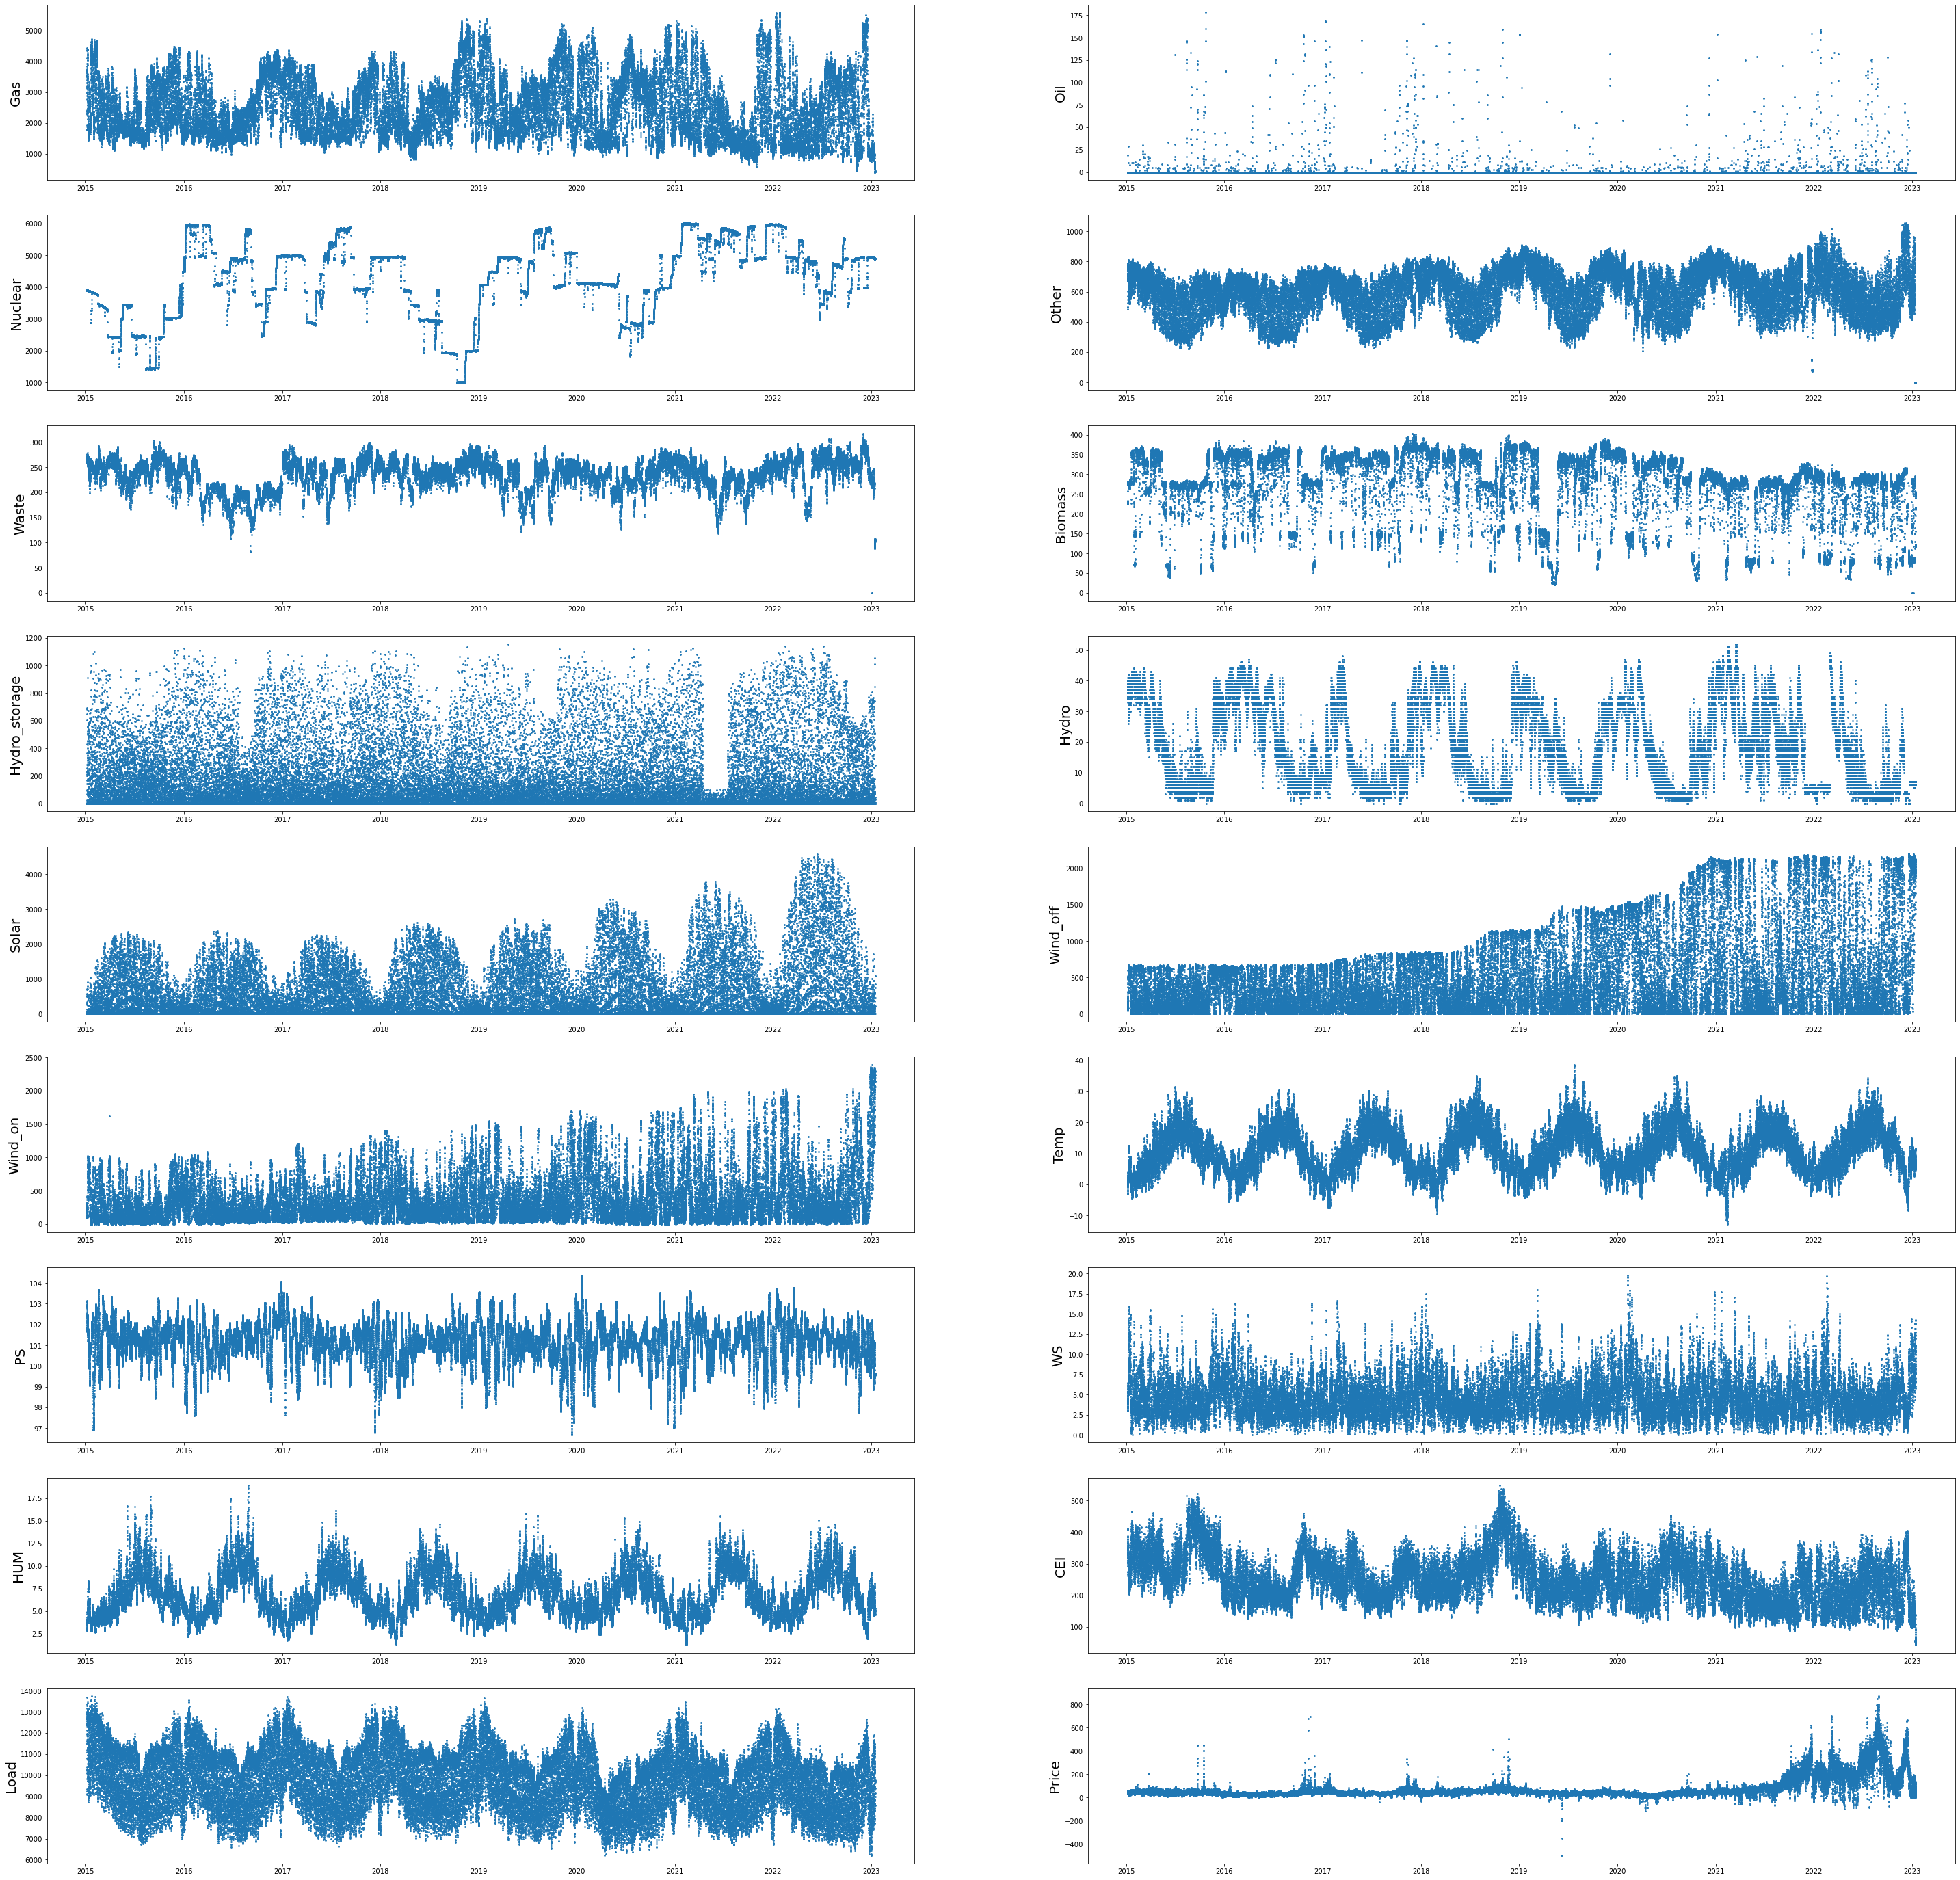

In [20]:
plot_multiple_scatter_charts(df)

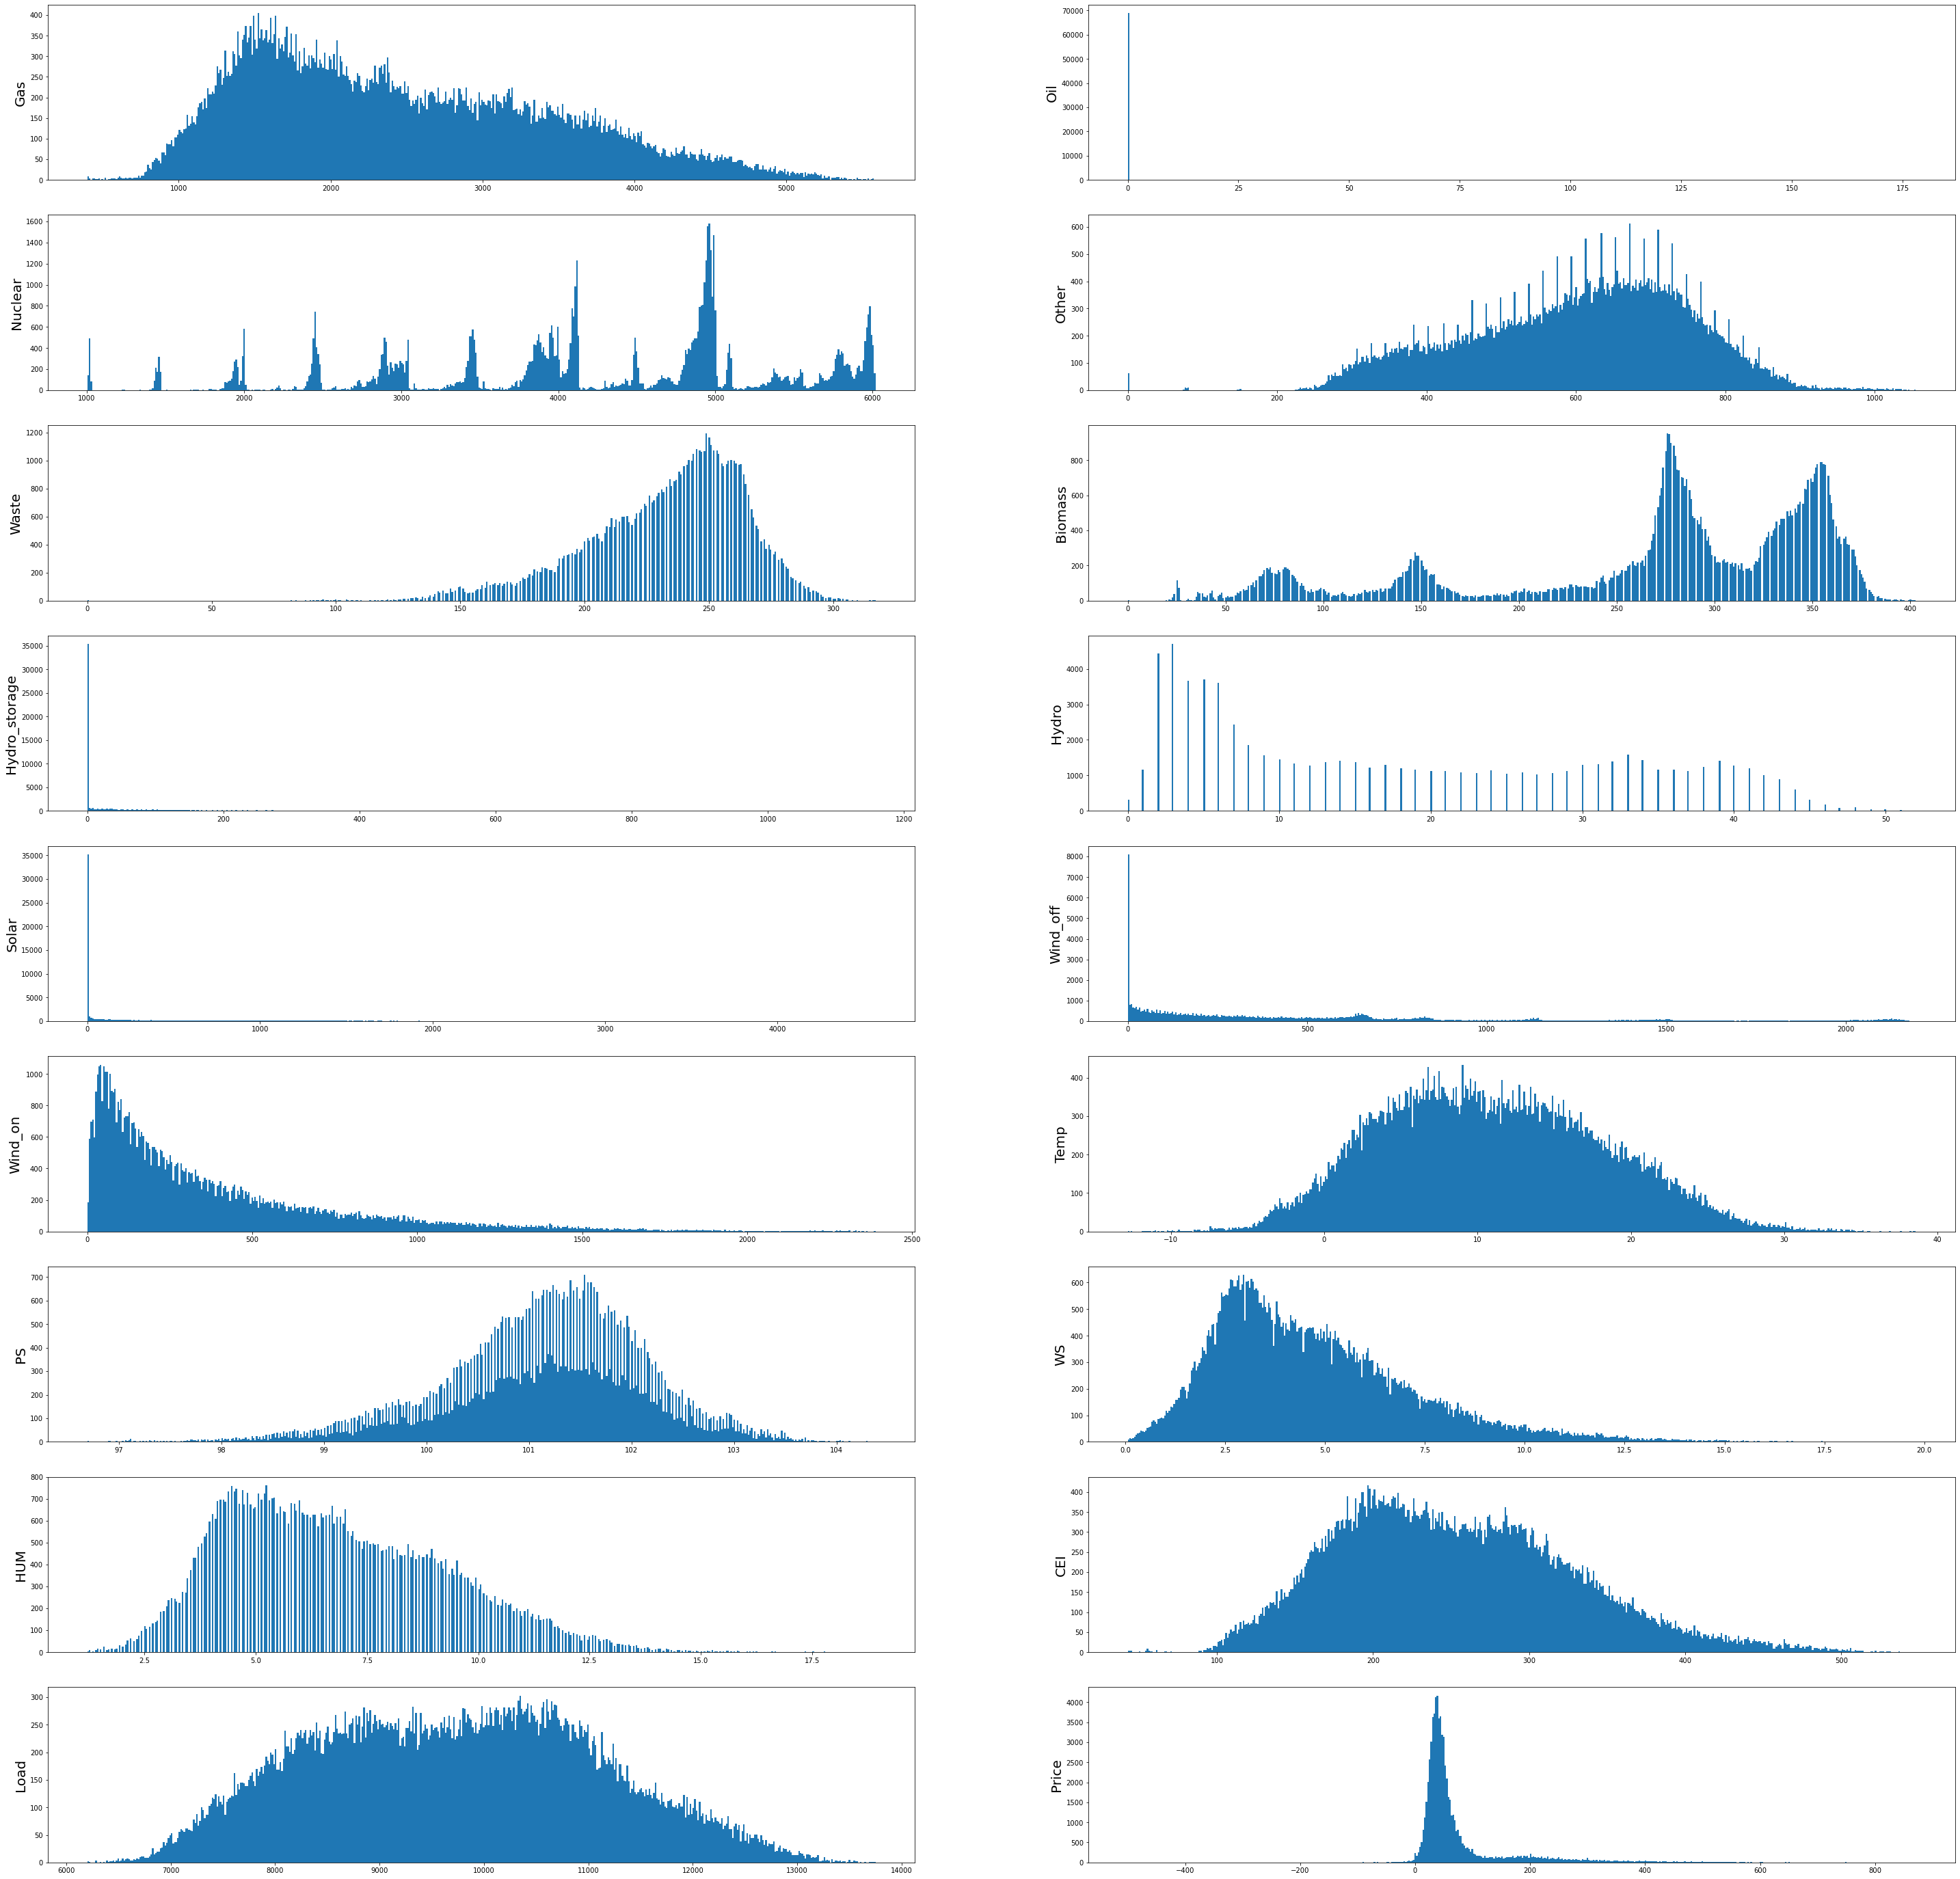

In [21]:
plot_multiple_histogram_charts(df)

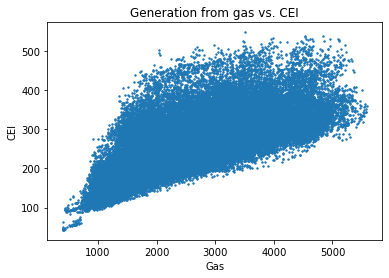

In [22]:
df.plot(kind="scatter", x="Gas", y="CEI", title="Generation from gas vs. CEI", s=2)
plt.show()

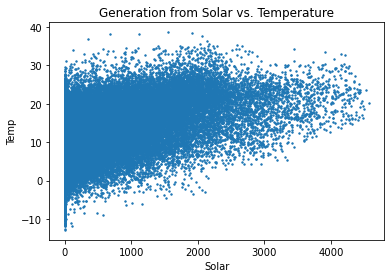

In [23]:
df.plot(
    kind="scatter",
    x="Solar",
    y="Temp",
    title="Generation from Solar vs. Temperature",
    s=2,
)
plt.show()

In [24]:
# sns.scatterplot(x='Solar', y='Temp', hue =df.index, data = df)

In [25]:
def add_lags(df):
    target_map = df["CEI"].to_dict()
    df["lag1"] = (df.index - pd.Timedelta("1 hour")).map(target_map)
    df["lag2"] = (df.index - pd.Timedelta("6 hours")).map(target_map)
    df["lag3"] = (df.index - pd.Timedelta("12 hours")).map(target_map)
    df["lag4"] = (df.index - pd.Timedelta("24 hours")).map(target_map)
    df["lag5"] = (df.index - pd.Timedelta("48 hours")).map(target_map)
    df["lag6"] = (df.index - pd.Timedelta("72 hours")).map(target_map)
    return df
df = add_lags(df)

/var/folders/k9/smv3l8753qx1p6_v2z5xb14m0000gn/T/ipykernel_22088/3088476981.py:3: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lag1"] = (df.index - pd.Timedelta("1 hour")).map(target_map)
/var/folders/k9/smv3l8753qx1p6_v2z5xb14m0000gn/T/ipykernel_22088/3088476981.py:4: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  df["lag2"] = (df.index - pd.Timedelta("6 hours")).map(target_map)
/var/folders/k9/smv3l8753qx1p6_v2z5xb14m0000gn/T/ipykernel_22088/3088476981.py:5: SettingWithCopyWarning: 
A value is trying 

In [26]:
def create_feature(df):
    """
    Create time series features based on time series index
    """
    df = df.copy()
    df["hour"] = df.index.hour
    df["dayofweek"] = df.index.day_of_week
    df["quarter"] = df.index.quarter
    df["month"] = df.index.month
    df["year"] = df.index.year
    df["dayofyear"] = df.index.day
    return df

In [27]:
df = create_feature(df)

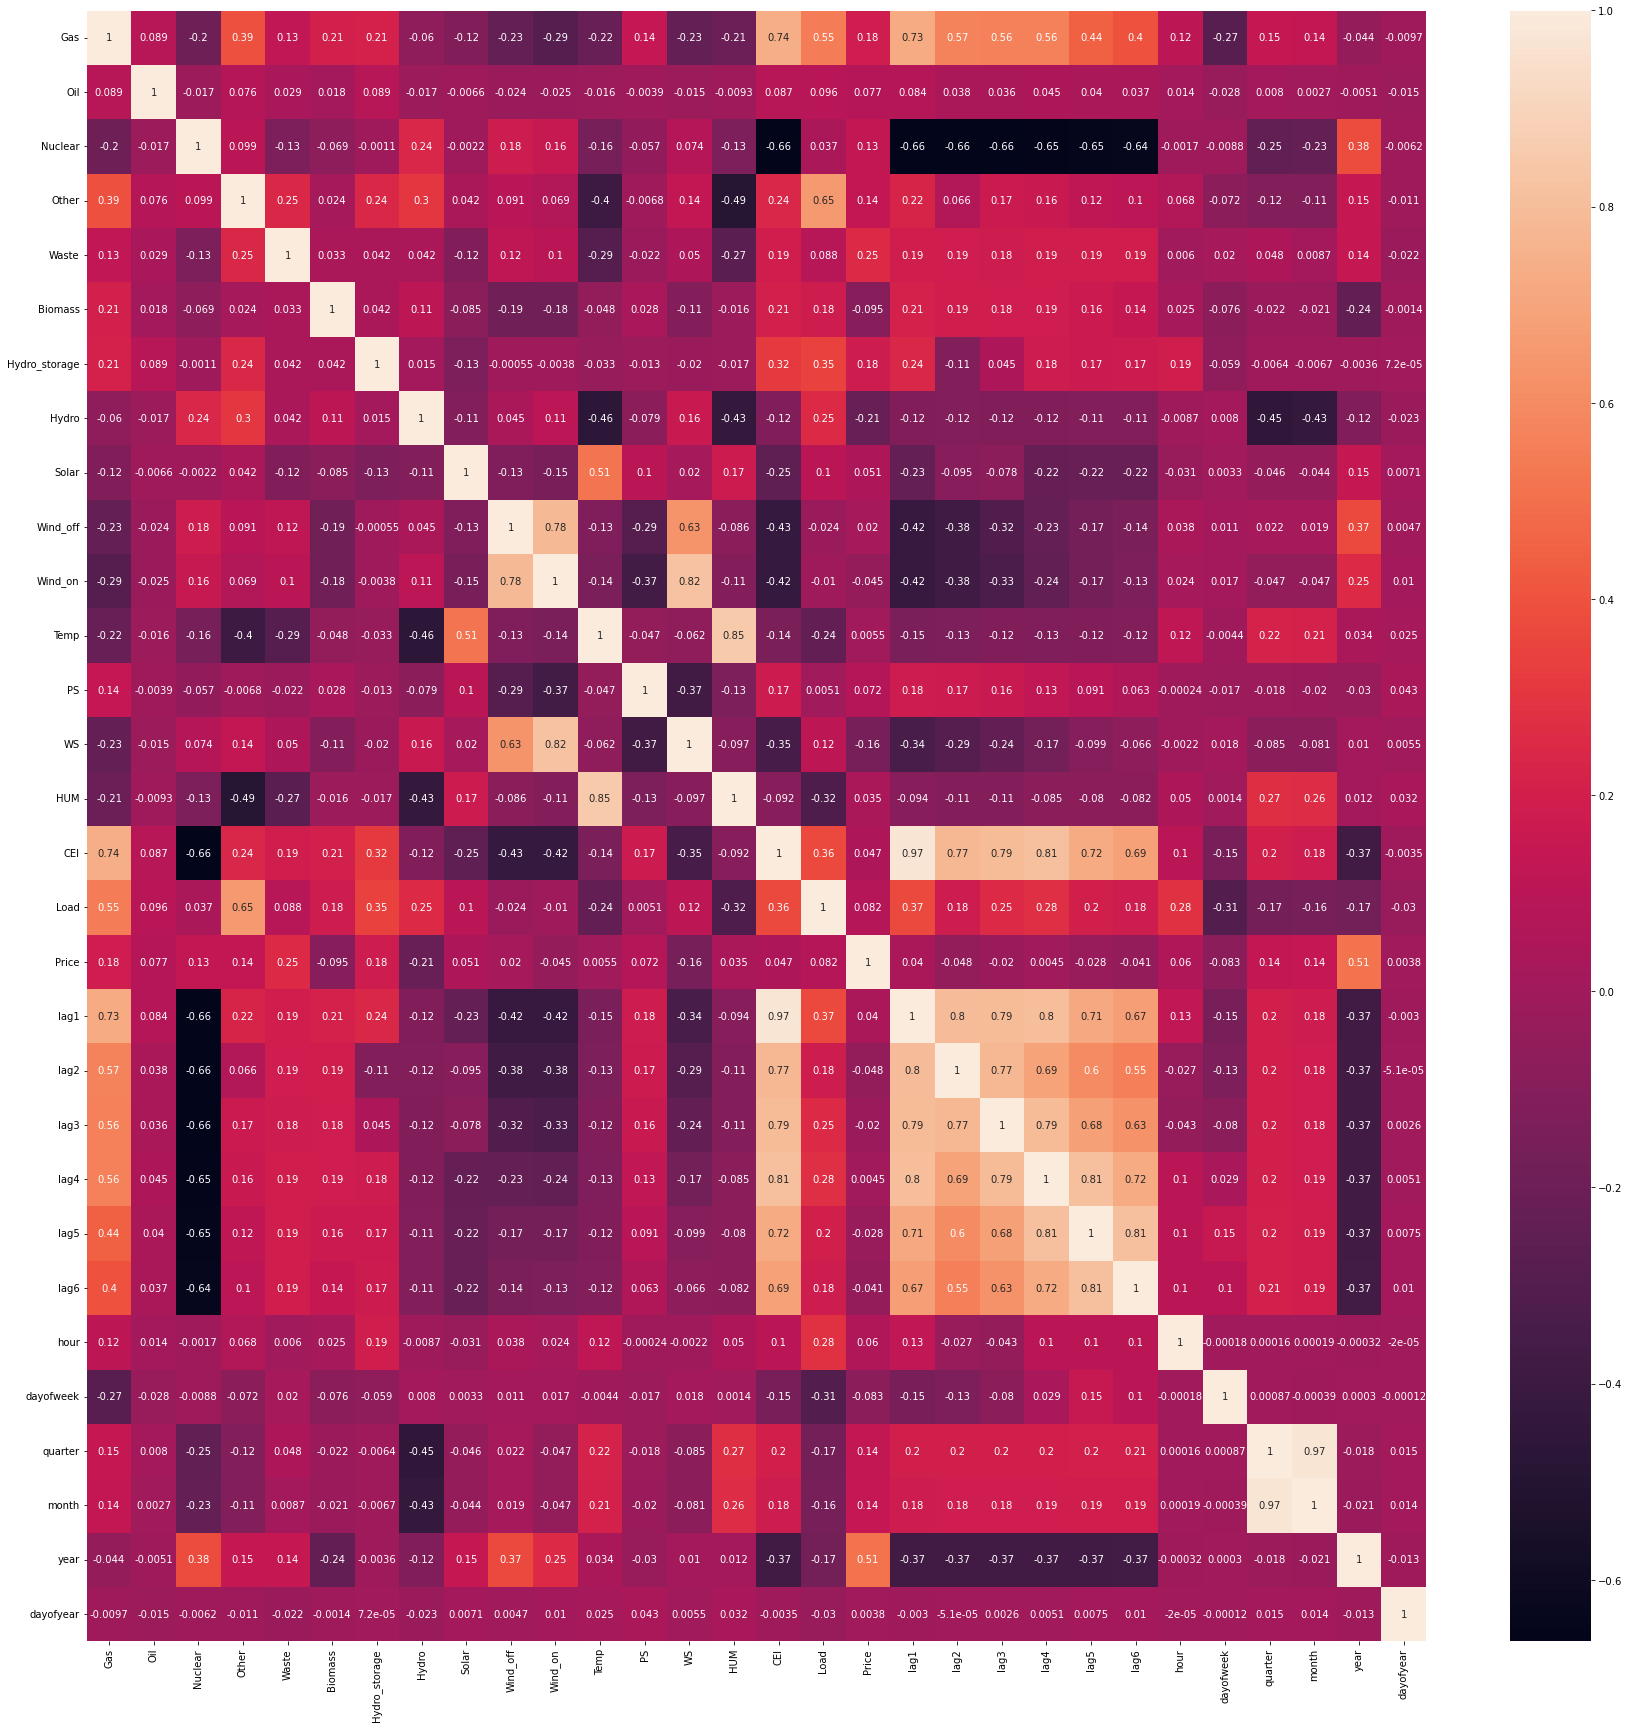

In [28]:
fig, ax = plt.subplots(figsize=(30, 30))
sns.heatmap(df.corr(), annot=True)
plt.show()

# XGBoost Model

In [29]:
FEATURES = [
    "Gas",
    "Oil",
    "Nuclear",
    "Other",
    "Waste",
    "Biomass",
    "Hydro_storage",
    "Hydro",
    "Solar",
    "Wind_off",
    "Wind_on",
    "Temp",
    "PS",
    "WS",
    "HUM",
    "Load",
    "Price",
    "hour",
    "dayofweek",
    "quarter",
    "month",
    "year",
    "dayofyear",
    "lag1",
    "lag2",
    "lag3",
    "lag4",
    "lag5",
    "lag6",
]
TARGET = "CEI"

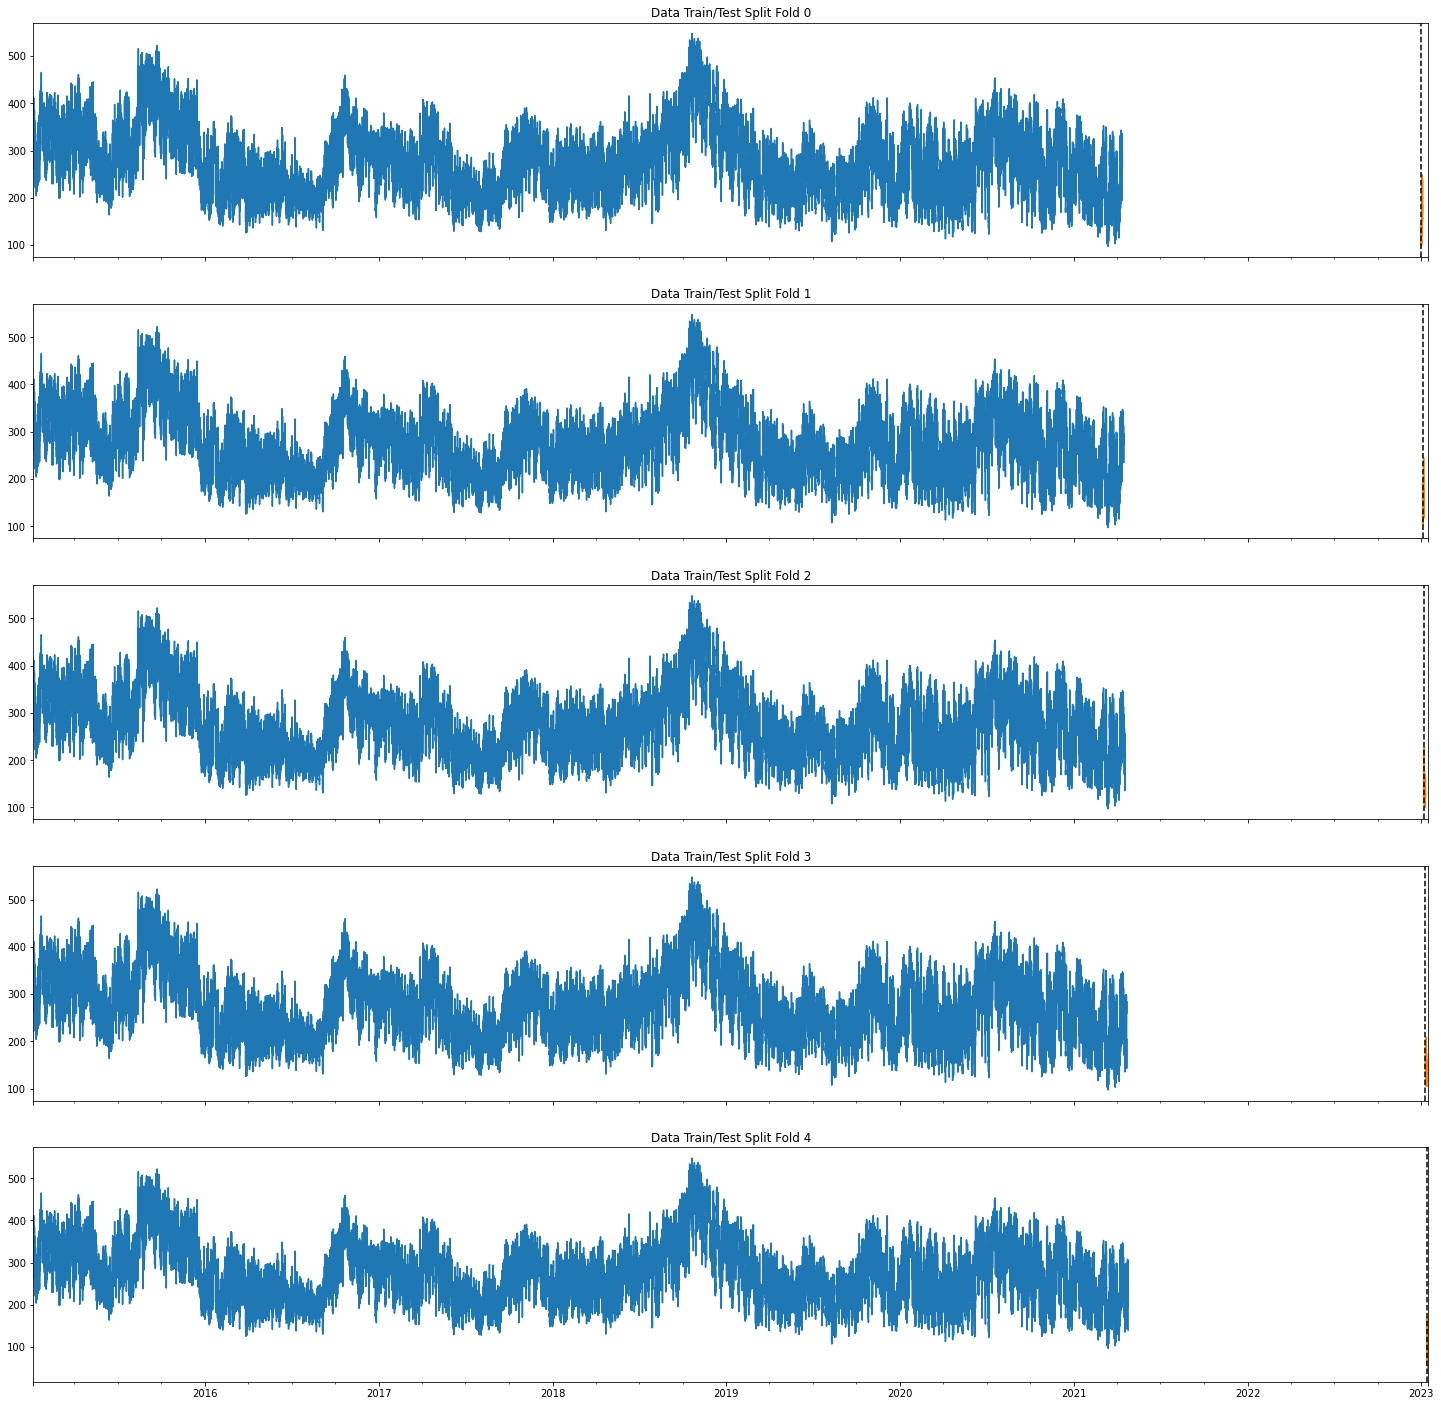

In [38]:
splits = 5
size = 24 * 3 * 1
gap = 15000

tss = TimeSeriesSplit(n_splits=splits, test_size=size, gap=gap)
df = df.sort_index()

for train_idx, val_idx in tss.split(df):
    break
    
fig, axs = plt.subplots(splits, 1, figsize=(25, 25), sharex=True)
fold = 0
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]
    train["CEI"].plot(
        ax=axs[fold], label="training set", title=f"Data Train/Test Split Fold {fold}"
    )
    test["CEI"].plot(ax=axs[fold], label="Test set")
    axs[fold].axvline(test.index.min(), color="black", ls="--")

    fold += 1

In [41]:
tss = TimeSeriesSplit(n_splits=splits, test_size=size, gap=gap)
df = df.sort_index()

fold = 0
preds = []
scores = []
for train_idx, val_idx in tss.split(df):
    train = df.iloc[train_idx]
    test = df.iloc[val_idx]

    train = create_feature(train)
    test = create_feature(test)

    X_train = train[FEATURES]
    y_train = train[TARGET]

    X_test = test[FEATURES]
    y_test = test[TARGET]

    reg = xgb.XGBRegressor(
        base_score=1,
        booster="gbtree",
        n_estimators=1000,
        early_stopping_rounds=50,
        objective="reg:linear",
        max_depth=3,
        learning_rate=0.1
    )

    reg.fit(
        X_train, y_train, eval_set=[(X_train, y_train), (X_test, y_test)], verbose=100
    )
    y_pred = reg.predict(X_test)
    preds.append(y_pred)
    score = np.sqrt(mean_squared_error(y_test, y_pred))
    scores.append(score)
    fold += 1

[23:47:55] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regression_obj.cu:213: reg:linear is now deprecated in favor of reg:squarederror.
[0]	validation_0-rmse:247.12183	validation_1-rmse:138.81612
[100]	validation_0-rmse:10.16762	validation_1-rmse:18.93886
[200]	validation_0-rmse:8.51365	validation_1-rmse:14.85075
[300]	validation_0-rmse:7.55315	validation_1-rmse:12.91032
[400]	validation_0-rmse:6.86137	validation_1-rmse:11.98411
[500]	validation_0-rmse:6.32714	validation_1-rmse:11.04394
[600]	validation_0-rmse:5.90618	validation_1-rmse:10.09667
[700]	validation_0-rmse:5.55358	validation_1-rmse:9.36735
[800]	validation_0-rmse:5.25951	validation_1-rmse:8.78524
[900]	validation_0-rmse:5.01200	validation_1-rmse:8.32586
[999]	validation_0-rmse:4.80331	validation_1-rmse:7.87499
[23:48:19] WARNING: /Users/runner/work/xgboost/xgboost/python-package/build/temp.macosx-11.0-arm64-cpython-38/xgboost/src/objective/regress

In [42]:
print(f"Score across folds {np.mean(scores):0.4f}")
print(f"Fold scores {scores}")

Score across folds 13.8407
Fold scores [7.874988802891042, 5.4819639417275186, 19.04651064300856, 6.098207478668542, 30.701665251446446]
